In [1]:
import os
import pickle
import shutil 

import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from IPython import embed

Using MPI version 4.0, 1 processes


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
resolution = 15

n_fusedSilica = 1.44
n_PDMS = 1.4
n_amorphousSi = 3.48

a = 0.680   # lattice period 

pml_thickness = 0.780
height_pillar = 1.020
width_PDMS = 1.560
width_fusedSilica = 0.780

cell_x = a
cell_y = a
cell_z = round(2*pml_thickness + width_PDMS + height_pillar +  width_fusedSilica, 3)

center_PDMS = round(0.5*(height_pillar + width_PDMS + pml_thickness) 
                    + (pml_thickness + width_fusedSilica) - 0.5*cell_z, 3)
center_fusedSilica = round(0.5*(pml_thickness + width_fusedSilica) - 0.5*cell_z, 3)
center_pillar = round(pml_thickness + width_fusedSilica + 0.5*height_pillar
                    - 0.5*cell_z, 3) 

z_fusedSilica = pml_thickness + width_fusedSilica
z_PDMS = height_pillar + width_PDMS + pml_thickness

In [3]:
geometry = [mp.Block(size=mp.Vector3(mp.inf,mp.inf,z_fusedSilica), 
                    center=mp.Vector3(0,0,center_fusedSilica),
                    material=mp.Medium(index=n_fusedSilica)),
            mp.Block(size=mp.Vector3(mp.inf,mp.inf,z_PDMS),
                    center=mp.Vector3(0,0,center_PDMS),
                    material=mp.Medium(index=n_PDMS))]
k_point = mp.Vector3(0,0,0)
#k_point = mp.Vector3(np.radians(35), 0, 0)  # k vector defines normal to the plane of propagation

wavelength = 1.55
freq = 1 / wavelength

## initialize matrix for data collection ##
##########################################

num = 6 # this is the number of pillars we will build
data = np.zeros((3,num))
dfts = []

## set up and build source ##
############################

center_source = round(pml_thickness + width_fusedSilica*0.2 - 0.5*cell_z, 3) 
source_cmpt = mp.Ey

fcen = freq
fwidth=0.2*freq

sources = [mp.Source(mp.GaussianSource(fcen, fwidth=fwidth), component = source_cmpt,
                            center=mp.Vector3(0,0,center_source),
                            size=mp.Vector3(cell_x,cell_y,0))]

def run_sim():
    sim.run(until_after_sources=mp.stop_when_fields_decayed(50, source_cmpt, mp.Vector3(0, 0, cell_z), 1e-2))

In [4]:
cell_size = mp.Vector3(cell_x,cell_y,cell_z)
pml_layers = [mp.PML(thickness = pml_thickness, direction = mp.Z)]

if source_cmpt == mp.Ey:
    symmetries = [mp.Mirror(mp.X, phase=+1), #epsilon has mirror symmetry in x and y, phase doesn't matter
                  mp.Mirror(mp.Y, phase=-1)] #but sources have -1 phase when reflected normal to their direction
elif src_cmpt == mp.Ex:                      #use of symmetries important here, significantly speeds up sim
    symmetries = [mp.Mirror(mp.X, phase=-1),
                  mp.Mirror(mp.Y, phase=+1)]
elif src_cmpt == mp.Ez:
    symmetries = [mp.Mirror(mp.X, phase=+1),
                  mp.Mirror(mp.Y, phase=+1)]



sim = mp.Simulation(cell_size=cell_size,
                    geometry=geometry,
                    sources=sources,
                    k_point=k_point,
                    boundary_layers=pml_layers,
                    symmetries=symmetries,
                    resolution=resolution)

nfreq = 1
df = 0
fr_center = round(0.5*cell_z - pml_thickness - 0.3*width_PDMS, 3)
fr = mp.FluxRegion(center=mp.Vector3(0,0,fr_center), 
            size=mp.Vector3(cell_x, cell_y, 0))

flux_object = sim.add_flux(freq, df, nfreq, fr)
where=mp.Volume(center=mp.Vector3(0, 0, fr_center), size=mp.Vector3(cell_x, cell_y, 0))
dft_object = sim.add_dft_fields([mp.Ex, mp.Ey, mp.Ez], freq, df, nfreq, where=where)
run_sim()

-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00227308 s
Working in 3D dimensions.
Computational cell is 0.666667 x 0.666667 x 4.93333 with resolution 15
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
time for set_epsilon = 0.033905 s
-----------
field decay(t = 50.03333333333333): 0.12280372618768592 / 0.12280372618768592 = 1.0
field decay(t = 100.06666666666666): 0.02958648037023179 / 0.12280372618768592 = 0.2409249400544538
field decay(t = 150.1): 3.231363431383704e-16 / 0.12280372618768592 = 2.631323602058361e-15
run 0 finished at t = 150.1 (4503 timesteps)


In [5]:
initial_flux = mp.get_fluxes(flux_object)[0]     # initial flux
initial_dft = [sim.get_dft_array(dft_object, mp.Ex, 0),
               sim.get_dft_array(dft_object, mp.Ey, 0),
               sim.get_dft_array(dft_object, mp.Ez, 0)]

sim.reset_meep()
print(initial_flux)

1.204076272043475


In [6]:
pbar = tqdm(total=num,leave=False)
for i,radius in enumerate(np.linspace(0.075,0.25,num=num)):
    geometry.append(mp.Cylinder(radius=radius,
                        height=height_pillar,
                        axis=mp.Vector3(0,0,1),
                        center=mp.Vector3(0,0,center_pillar),
                        material=mp.Medium(index=n_amorphousSi)))

    sim = mp.Simulation(cell_size=cell_size,
                        geometry=geometry,
                        sources=sources,
                        k_point=k_point,
                        boundary_layers=pml_layers,
                        symmetries=symmetries,
                        resolution=resolution)
    
    flux_object = sim.add_flux(freq, df, nfreq, fr)
    dft_object = sim.add_dft_fields([mp.Ex, mp.Ey, mp.Ez], freq, df, nfreq, where=where)

    run_sim()
    
    res = sim.get_eigenmode_coefficients(flux_object, [1], eig_parity=mp.ODD_Y)
    coeffs = res.alpha

    flux = abs(coeffs[0,0,0]**2)
    phase = np.angle(coeffs[0,0,0]) 
    
    data[0,i] = radius
    data[1,i] = flux
    data[2,i] = phase
    # dft_arrays = {}
    # dft_arrays['ex'] = sim.get_dft_array(dft_object, mp.Ex, 0)
    # dft_arrays['ey'] = sim.get_dft_array(dft_object, mp.Ey, 0)
    # dft_arrays['ez'] = sim.get_dft_array(dft_object, mp.Ez, 0)
    dfts.append([sim.get_dft_array(dft_object, mp.Ex, 0), sim.get_dft_array(dft_object, mp.Ey, 0), sim.get_dft_array(dft_object, mp.Ez, 0)])

    
    if(radius!=0.25):
        sim.reset_meep()
        print(f"i= {i},radius={radius}")
        geometry.pop(-1)
    pbar.update(1)
pbar.close()

  0%|                                                                              | 0/6 [00:00<?, ?it/s]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00190592 s
Working in 3D dimensions.
Computational cell is 0.666667 x 0.666667 x 4.93333 with resolution 15
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (0,0,-0.39)
          radius 0.075, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.0410459 s
-----------
field decay(t = 50.03333333333333): 0.023123318922198707 / 0.023123318922198707 = 1.0
field decay(t = 100.06666666666666): 0.005589807114636813 / 0.023123318922198707 

field decay(t = 150.1): 1.623687614252031e-15 / 0.023123318922198707 = 7.021862301493703e-14
run 0 finished at t = 150.1 (4503 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 8 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 17%|███████████▋                                                          | 1/6 [00:00<00:02,  1.77it/s]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 0,radius=0.075
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00171304 s
Working in 3D dimensions.
Computational cell is 0.666667 x 0.666667 x 4.93333 with resolution 15
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (0,0,-0.39)
          radius 0.11, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.0316579 s
-----------
field decay(t = 50.03333333333333): 0.03469271856662571 / 0.03469271856662571 = 1.0
field decay(t = 100.06666666666666): 0.008729849600046113 / 0.0346

field decay(t = 150.1): 9.777870060094282e-15 / 0.03469271856662571 = 2.8184214048594517e-13
run 0 finished at t = 150.1 (4503 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 8 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 33%|███████████████████████▎                                              | 2/6 [00:01<00:02,  1.82it/s]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 1,radius=0.10999999999999999
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00170398 s
Working in 3D dimensions.
Computational cell is 0.666667 x 0.666667 x 4.93333 with resolution 15
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (0,0,-0.39)
          radius 0.145, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.03019 s
-----------
field decay(t = 50.03333333333333): 0.10795651246296238 / 0.10795651246296238 = 1.0
field decay(t = 100.06666666666666): 0.03172312128393

field decay(t = 150.1): 7.999889356426389e-13 / 0.10795651246296238 = 7.410288804180279e-12
run 0 finished at t = 150.1 (4503 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 8 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 50%|███████████████████████████████████                                   | 3/6 [00:01<00:01,  1.82it/s]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 2,radius=0.145
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00166702 s
Working in 3D dimensions.
Computational cell is 0.666667 x 0.666667 x 4.93333 with resolution 15
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (0,0,-0.39)
          radius 0.18, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.031173 s
-----------
field decay(t = 50.03333333333333): 0.15749753918792253 / 0.15749753918792253 = 1.0
field decay(t = 100.06666666666666): 0.0755221343218776 / 0.1574975

field decay(t = 150.1): 0.0008210500868987142 / 0.15749753918792253 = 0.005213097875256677
run 0 finished at t = 150.1 (4503 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 8 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 67%|██████████████████████████████████████████████▋                       | 4/6 [00:02<00:01,  1.80it/s]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 3,radius=0.18
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00171494 s
Working in 3D dimensions.
Computational cell is 0.666667 x 0.666667 x 4.93333 with resolution 15
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (0,0,-0.39)
          radius 0.215, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.03512 s
-----------
field decay(t = 50.03333333333333): 0.11549536651998578 / 0.11549536651998578 = 1.0
field decay(t = 100.06666666666666): 0.04019080196248548 / 0.1154953

field decay(t = 150.1): 7.62478911000304e-06 / 0.11549536651998578 = 6.601813856042109e-05
run 0 finished at t = 150.1 (4503 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 8 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 83%|██████████████████████████████████████████████████████████▎           | 5/6 [00:02<00:00,  1.80it/s]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 4,radius=0.21499999999999997
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.001652 s
Working in 3D dimensions.
Computational cell is 0.666667 x 0.666667 x 4.93333 with resolution 15
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (0,0,-0.39)
          radius 0.25, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.0354111 s
-----------
field decay(t = 50.03333333333333): 0.21578131616824756 / 0.21578131616824756 = 1.0
field decay(t = 100.06666666666666): 0.134023886675952

field decay(t = 750.5): 0.0018854260566181164 / 0.21578131616824756 = 0.008737670573609926
run 0 finished at t = 750.5 (22515 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 8 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


In [7]:
def get_intensity(Ex, Ey, Ez):
    E_0 = np.sqrt((abs(Ex)**2 + abs(Ey)**2 + abs(Ez)**2))
    I = 0.5 * E_0**2
    return(np.mean(I))

initial_I = get_intensity(initial_dft[0], initial_dft[1], initial_dft[2])
I_list = []
for dft in dfts:
    I = get_intensity(dft[0], dft[1], dft[2])
    I_list.append(I / initial_I)

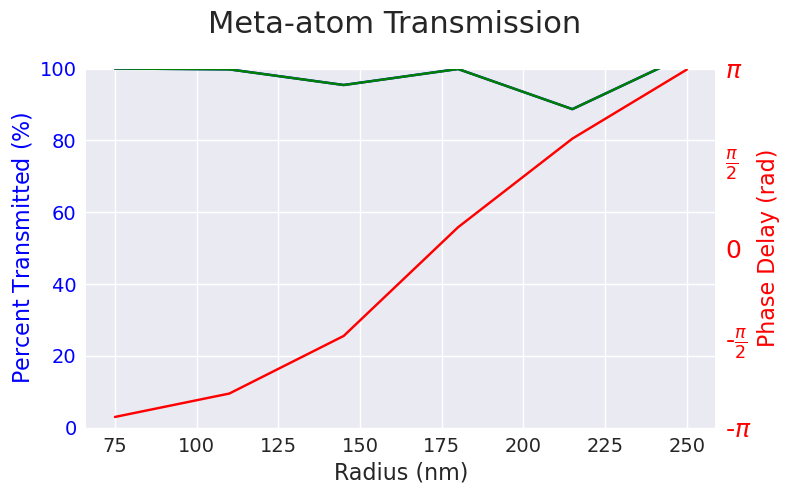

In [8]:
radii = data[0,:]
flux_list = data[1,0:] / initial_flux
phase_list = data[2,0:]

#plt.style.use('seaborn')

results = {"radii": radii, "flux": flux_list, "phase": phase_list}
# this section plots radius vs. phas and transmission
plt.style.use('seaborn-v0_8')

tickfontsize=14
labelfontsize=16
titlefontsize=22
plt.close("all")
fig,ax = plt.subplots(figsize=(8,5)) # may want to change. Also see DPI keyword

fig.suptitle("Meta-atom Transmission",fontsize=titlefontsize)

#ax.set_title("Transmission Magnitude",fontsize=titlefontsize)

ax.set_xlabel("Radius (nm)",fontsize=labelfontsize)
ax.set_xticks([0.075,0.100,0.125,0.150,0.175,0.200,0.225,0.250])
ax.set_xticklabels([75,100,125,150,175,200,225,250],fontsize=tickfontsize)
ax.set_ylim([0,1])
ax.set_ylabel(r'Percent Transmitted ($\%$)',fontsize=labelfontsize, color = 'blue')
ax.plot(radii,flux_list,'b',label='Transmission')
ax.plot(radii,I_list,'green',label='DFT Transmission')
ax.tick_params(axis='y', labelcolor = 'blue')

ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0, 20,40,60,80,100],fontsize=tickfontsize)

twin1 = ax.twinx()

twin1.set_ylim([-np.pi,np.pi])
twin1.set_ylabel(r'Phase Delay (rad)',fontsize=labelfontsize, color = 'red')
twin1.set_yticks([-np.pi, -(0.5*np.pi),0, np.pi / 2, np.pi])
twin1.set_yticklabels([r'-$\pi$',r'-$\frac{\pi}{2}$',r'0',r'$\frac{\pi}{2}$',r'$\pi$'],fontsize=tickfontsize+4)
twin1.plot(radii,phase_list,'r',label='Phase')
twin1.tick_params(axis='y', labelcolor = 'red')
#ax[1].legend(loc="upper right")
#plt.legend(loc="upper right")
plt.grid(False)
plt.tight_layout()

In [ ]:
type(initial_dft[0])

In [ ]:
len(dfts)

In [ ]:
initial_I